# GPflow with TF 2.0

In [1]:
from typing import Tuple
from pathlib import Path

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

from gpflow.config import default_float

import warnings

warnings.filterwarnings('ignore')

tb_logdir = "/tmp/tensorboard"  # type: str

!rm -rf "{tb_logdir}"

def enumerated_logdir(_logdir_id: int = [0]):
    logdir = Path(tb_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)
    

!mkdir "{tb_logdir}"
%load_ext tensorboard
%matplotlib notebook


np.random.seed(0)
tf.random.set_seed(0)
gpflow.config.set_default_float(np.float64)

## Loading data using TensorFlow Datasets

For this example, we create a synthetic dataset (noisy sine function) 

(0, 10)

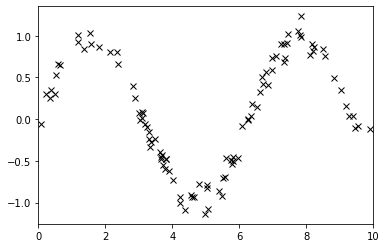

In [2]:
def noisy_sin(x): 
    return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())

num_train_data, num_test_data = 100, 500

X = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 10
Xtest = tf.random.uniform((num_test_data, 1), dtype=default_float()) * 10

Y = noisy_sin(X)
Ytest = noisy_sin(Xtest)

plt.plot(X, Y, 'xk')
plt.xlim(0, 10)

Working with Tensorflow Datasets is an efficient way to rapidly shuffle, iterate and batch from data.

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32
num_features = 10
prefetch_size = num_train_data // 2
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = train_dataset.repeat().prefetch(prefetch_size).shuffle(buffer_size=shuffle_buffer_size).batch(batch_size)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

W0622 21:48:01.046863 4372366784 deprecation.py:323] From /Users/artemav/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow_core/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


prefetch_size=50
shuffle_buffer_size=50
num_batches_per_epoch=3


## Define a GP model

In GPflow2.0, we use tf.Module to build all our models, as well as, their components (kernels, likelihoods, parameters, etc.). 

In [4]:
kernel = gpflow.kernels.RBF(variance=2.)
likelihood = gpflow.likelihoods.Gaussian()
features = np.linspace(0, 10, num_features).reshape(-1, 1)

model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, feature=features)

You can set a module (or a particular parameter) to be non-trainable using the auxiliary method ```set_trainable(module, False)```

In [5]:
from gpflow.utilities.training import set_trainable

set_trainable(likelihood, False)
set_trainable(kernel.variance, False)

set_trainable(likelihood, True)
set_trainable(kernel.variance, True)

We can use ```param.assign(value)``` to assign a value to a parameter:

In [6]:
kernel.lengthscale.assign(0.5)

All these changes are reflected when we use ```print_summary(model)``` to print a detailed summary of the model.

In [7]:
# from gpflow.utilities.printing import print_summary
# print_summary(model)

## Training using Gradient Tapes

In TensorFlow2.0, we can optimise (trainable) model parameters with Tensorflow optimizers using GradientTapes. In this simple example, we perform one gradient update of the Adam optimizer to minimize the negative marginal log likelihood (or ELBO) of our model.

In [8]:
optimizer = tf.optimizers.Adam()

with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    elbo = model.elbo(X, Y)
    grads = tape.gradient(elbo, model.trainable_variables)
    
optimizer.apply_gradients(zip(grads, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

For a more elaborare example of a gradient update we can define an ```optimization_step``` that uses decorator ```tf.function``` on a closure. A closure is callable that returns the model objective evaluated at a given dataset when called.

In [9]:
def optimization_step(model: gpflow.models.SVGP, batch: Tuple[tf.Tensor, tf.Tensor]):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        elbo = model.elbo(*batch)
        grads = tape.gradient(elbo, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

We can make use the functionality of TensorFlow Datasets to define a simple training loop that iterates over batches of the training dataset: 

In [10]:
def simple_training_loop(model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10):
    batches = iter(train_dataset)
    tf_optimization_step = tf.function(optimization_step)
    for epoch in range(epochs):
        for _ in range(num_batches_per_epoch):
            tf_optimization_step(model, next(batches))

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(X, Y)}")

In [11]:
simple_training_loop(model, epochs=10, logging_epoch_freq=2)

W0622 21:48:08.433741 4372366784 ag_logging.py:145] Entity <bound method Dispatcher.dispatch_iter of <dispatched conditional>> appears to be a generator function. It will not be converted by AutoGraph.


W0622 21:48:09.151643 4372366784 ag_logging.py:145] Entity <bound method Dispatcher.dispatch_iter of <dispatched Kuf>> appears to be a generator function. It will not be converted by AutoGraph.


Epoch 2: ELBO (train) 212.29663302150476
Epoch 4: ELBO (train) 211.04060658136456
Epoch 6: ELBO (train) 209.76161048220303
Epoch 8: ELBO (train) 208.46305694165406
Epoch 10: ELBO (train) 207.13941719416468


## Monitoring 

We can monitor the training procedure using TensorFlow summary. First we create a summary writer object under which we can write scalar and images.

In [14]:
from intro_to_gpflow2_plotting import plotting_regression, summary_matplotlib_image

samples_input = tf.cast(np.linspace(0, 10, 100).reshape(100, 1), default_float())

def monitored_training_loop(model: gpflow.models.SVGP, logdir: str, epochs: int = 1, logging_epoch_freq: int = 10, num_samples: int = 10):
    summary_writer = tf.summary.create_file_writer(logdir)
    tf_optimization_step = tf.function(optimization_step)
    batches = iter(train_dataset)

    with summary_writer.as_default():
        for epoch in range(epochs):
            for _ in range(num_batches_per_epoch):
                tf_optimization_step(model, next(batches))

            epoch_id = epoch + 1
            if epoch_id % logging_epoch_freq == 0:
                tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(X, Y)}")

                mean, var = model.predict_f(samples_input)
                samples = model.predict_f_samples(samples_input, num_samples)
                fig = plotting_regression(X, Y, samples_input, mean, var, samples)
                
                summary_matplotlib_image(dict(model_samples=fig), step=epoch)
                tf.summary.scalar('elbo', data=model.elbo(X, Y), step=epoch)
                tf.summary.scalar('likelihood/variance', data=model.likelihood.variance, step=epoch)
                tf.summary.scalar('kernel/lengthscale', data=model.kernel.lengthscale, step=epoch)
                tf.summary.scalar('kernel/variance', data=model.kernel.variance, step=epoch)

In [15]:
model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, feature=features)

output_logdir = enumerated_logdir()
monitored_training_loop(model, output_logdir, epochs=1000, logging_epoch_freq=100)
print(f"output_dir = {output_logdir}")

Epoch 100: ELBO (train) 144.14400885717626
Epoch 200: ELBO (train) 118.77724182234402
Epoch 300: ELBO (train) 111.3789308748235
Epoch 400: ELBO (train) 108.96818161780133
Epoch 500: ELBO (train) 107.86963393758975
Epoch 600: ELBO (train) 107.16827880009352
Epoch 700: ELBO (train) 106.64628531041235
Epoch 800: ELBO (train) 106.24895329819464
Epoch 900: ELBO (train) 105.94935349804861
Epoch 1000: ELBO (train) 105.7389757898661
output_dir = /tmp/tensorboard/0


Then, we can then use TensorBoard to examine the training procedure more in detail

In [16]:
%tensorboard --logdir "{tb_logdir}"

Reusing TensorBoard on port 6007 (pid 1594), started 9:35:29 ago. (Use '!kill 1594' to kill it.)

## Checkpointing: saving and loading models

With the help of `tf.train.CheckpointManager` and `tf.train.Checkpoint`, we can checkpoint the model throughout the training procedure. Let's start with a simple example using checkpointing to save and load `tf.Variables`:

In [16]:
a = tf.Variable(1.2)
# Create Checkpoint object
checkpoint_obj = tf.train.Checkpoint(a=a)
checkpoint_path = '/tmp/simple_example/' + datetime.datetime.now().strftime("%Y%m%d-%H%M")
manager = tf.train.CheckpointManager(checkpoint_obj, checkpoint_path, max_to_keep=10)
# Save variable
manager.save()
a.assign(0.33)
print('Current value of variable a: %f' % (a.numpy()))
checkpoint_obj.restore(manager.latest_checkpoint)
print('Value of variable a: %f' % (a.numpy()))

Current value of variable a: 0.330000
Value of variable a: 1.200000


In this example bellow, we modify a simple training loop to save the model every 100 epochs using the CheckpointManager.

In [17]:
model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, feature=feature)

def checkpointing_training_loop(model, batch_size: int, epochs: int, manager: tf.train.CheckpointManager):
    num_batches_per_epoch = int(N / batch_size)
    batches = iter(dataset)
    for epoch in range(epochs):
        for _ in range(num_batches_per_epoch):
            batch = next(batches_epoch)
            optimization_step(batch)
        epoch_id = epoch + 1
        if epoch_id % 100 == 0:
            ckpt_path = manager.save()
            tf.print(f"Epoch {epoch_it}: ELBO (train) {model.elbo(X, Y)}, saved at {ckpt_path}")

In [19]:
checkpoint_path = enumerated_logdir()
print(f"TensorFlow logdir for this run: {checkpoint_path}")

ckpt = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)
print(f"Checkpoint folder path at: {checkpoint_path}")

checkpointing_training_loop(model, batch_size=batch_size, epochs=1000, manager=manager)

Checkpoint folder path at: /tmp/tf_ckpts/20190620-1739
Epoch 100 completed: ELBO training set 108.2411683, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-1
Epoch 200 completed: ELBO training set 107.1402743, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-2
Epoch 300 completed: ELBO training set 107.0170233, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-3
Epoch 400 completed: ELBO training set 106.9882623, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-4
Epoch 500 completed: ELBO training set 106.9795233, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-5
Epoch 600 completed: ELBO training set 106.9766403, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-6
Epoch 700 completed: ELBO training set 106.9756183, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-7
Epoch 800 completed: ELBO training set 106.9751813, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-8
Epoch 900 complet

Once the models have been saved, we can resore them using ```tf.train.Checkpoint.restore``` and assert their performance corresponds to the logs during training.

In [20]:
for i, recorded_checkpoint in enumerate(manager.checkpoints): 
    ckpt.restore(recorded_checkpoint)
    print(r'Restored model from epoch %i : ELBO training set %f3' % (
        i + 1, model.neg_log_marginal_likelihood(X,Y))
         )

Restored model from epoch 1 : ELBO training set 108.2411683
Restored model from epoch 2 : ELBO training set 107.1402743
Restored model from epoch 3 : ELBO training set 107.0170233
Restored model from epoch 4 : ELBO training set 106.9882623
Restored model from epoch 5 : ELBO training set 106.9795233
Restored model from epoch 6 : ELBO training set 106.9766403
Restored model from epoch 7 : ELBO training set 106.9756183
Restored model from epoch 8 : ELBO training set 106.9751813
Restored model from epoch 9 : ELBO training set 106.9749173
Restored model from epoch 10 : ELBO training set 106.9746913


In [ ]:
warnings.filterwarnings('ignore')